# Identifying Sarcasm Based on Textual Data

In [ ]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertModel,BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk, csv, string, random, os, pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

ENGLISH_STOPWORDS = stopwords.words('english')
PUNCTUATIONS = string.punctuation
LEMMATIZER = WordNetLemmatizer()
STEMMER = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, cache_dir="./bert_cache")
model = BertForSequenceClassification.from_pretrained(model_name, cache_dir="./bert_cache")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset = pd.read_csv('https://drive.google.com/uc?export=download&id=1usrq7Gl3iVngx4-IbbczLl1dyK38JeOC')
dataset.dropna()
dataset.head()

,label,comment
0,1,Yes that's why I don't advocate for the rights...
1,1,I can find you a Pinsir if you want one that bad.
2,0,"Huh, that's pretty interesting actually thanks..."
3,1,TIL a monsoon = average summer weather in Sweden
4,1,Yeah everyone knows holographic tigers and bom...


In [ ]:
max_length = 100
tokenized_texts = [tokenizer.encode(str(text), add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length') for text in dataset['comment']]
input_ids = torch.tensor(tokenized_texts)
labels = torch.tensor(dataset['label'].values)

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks = (train_inputs != tokenizer.pad_token_id).type(torch.float32)
test_masks = (test_inputs != tokenizer.pad_token_id).type(torch.float32)

In [ ]:
batch_size = 64
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 11
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/11, Loss: 363.9225705564022
Epoch 2/11, Loss: 301.37061780691147
Epoch 3/11, Loss: 224.29915599524975
Epoch 4/11, Loss: 137.34155689179897
Epoch 5/11, Loss: 79.50687924958766
Epoch 6/11, Loss: 55.23809692822397
Epoch 7/11, Loss: 37.81900570495054
Epoch 8/11, Loss: 32.36275566625409
Epoch 9/11, Loss: 27.55986850266345
Epoch 10/11, Loss: 23.86909534095321
Epoch 11/11, Loss: 21.289752098033205


In [ ]:
model.eval()
predictions = []
true_labels = []
for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs, masks, labels = batch
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7284


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      4984
           1       0.75      0.69      0.72      5016

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



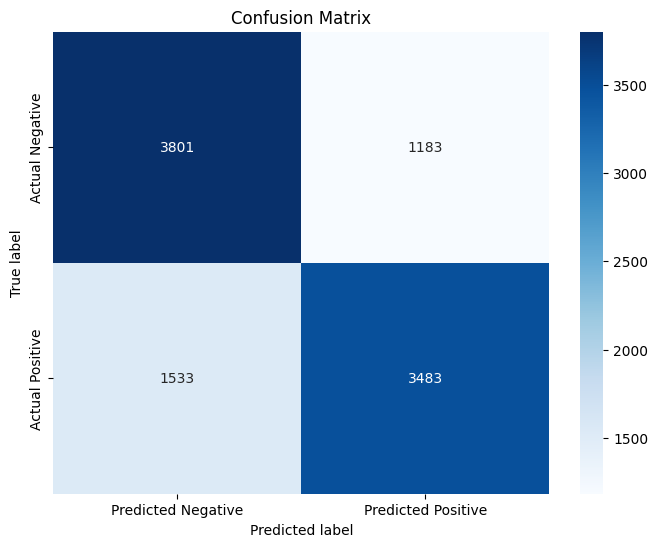

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predict  = pd.DataFrame(predictions)
ytest = pd.DataFrame(true_labels)

In [ ]:
predict.to_csv('predict_BERT50k.csv', index=False)

In [ ]:
ytest.to_csv('y_true_BERT50k.csv', index=False)

In [ ]:
yt = pd.read_csv("y_true_BERT50k.csv")
yp = pd.read_csv("predict_BERT50k.csv")

In [ ]:
print(f"F1 SCORE: {f1_score(yt, yp)}")

F1 SCORE: 0.7194794463953729
